# Monto Estimado



#### Librerias y conexión

Librerias

In [1]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib

sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)

from utils.bq_conn import bq_conn_file

bq_client = bq_conn_file(project_id="dsa-miad-365616")

# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns

# Transformación de las Variables y Modelos ML
# ==========================================
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

Consulta SQL.

In [2]:
query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''

In [6]:
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset es de: {secop_I.shape[0]}\nEl número de columnas del dataset es de: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset es de: 26553
El número de columnas del dataset es de: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,...,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,...,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,...,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,...,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,...,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,...,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


#### Eliminación de columnas irrelevantes

In [8]:
# eliminación de variables con información poco relevante de acuerdo con el análisis exploratorio
secop_I_filter = secop_I.filter(items=['tipo_de_contrato', 
                'id_grupo', 
                'cuantia_proceso',
                'departamento_ejecucion',
                'plazo_de_ejec_del_contrato_',
                'id_objeto_a_contratar',
                'valor_contrato_con_adiciones',
                                      ])
secop_I_filter.columns

Index(['tipo_de_contrato', 'id_grupo', 'cuantia_proceso',
       'departamento_ejecucion', 'plazo_de_ejec_del_contrato_',
       'id_objeto_a_contratar', 'valor_contrato_con_adiciones'],
      dtype='object')

#### Casteo de las variables

In [9]:
# casteo de las variables
secop_I_filter['tipo_de_contrato'] = secop_I_filter['tipo_de_contrato'].astype('category')
secop_I_filter['departamento_ejecucion'] = secop_I_filter['departamento_ejecucion'].astype('category')
secop_I_filter['id_objeto_a_contratar'] = secop_I_filter['id_objeto_a_contratar'].astype('category')
secop_I_filter['cuantia_proceso'] = secop_I_filter['cuantia_proceso'].astype('int')
secop_I_filter['plazo_de_ejec_del_contrato_'] = secop_I_filter['plazo_de_ejec_del_contrato_'].astype('int')
secop_I_filter['valor_contrato_con_adiciones'] = secop_I_filter['valor_contrato_con_adiciones'].astype('int')

In [10]:
secop_I_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   tipo_de_contrato              26553 non-null  category
 1   id_grupo                      26553 non-null  object  
 2   cuantia_proceso               26553 non-null  int64   
 3   departamento_ejecucion        26553 non-null  category
 4   plazo_de_ejec_del_contrato_   26553 non-null  int64   
 5   id_objeto_a_contratar         26553 non-null  category
 6   valor_contrato_con_adiciones  26553 non-null  int64   
dtypes: category(3), int64(3), object(1)
memory usage: 911.9+ KB


#### Preprocesamiento

##### Eliminación de outliers

In [11]:
# Dimensiones del dataset
# ==============================================================================
secop_I.shape

(26553, 38)

In [12]:
# Tratamiento de outliers valor_contrato_con_adiciones
Q1 = np.percentile(secop_I_filter['valor_contrato_con_adiciones'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(secop_I_filter['valor_contrato_con_adiciones'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", secop_I_filter.shape)
 
# Upper bound
upper = Q3+1.5*IQR
upper_array = secop_I_filter.loc[secop_I_filter['valor_contrato_con_adiciones']>=upper].index.to_list()

# Lower bound
lower = Q1-1.5*IQR
lower_array = secop_I_filter.loc[secop_I_filter['valor_contrato_con_adiciones']<=lower].index.to_list()

# Removing the outliers
secop_I_filter.drop(upper_array, inplace=True)
secop_I_filter.drop(lower_array, inplace=True)
secop_I_filter.reset_index(drop=True, inplace=True)
 
print("New Shape: ", secop_I_filter.shape)

Old Shape:  (26553, 7)
New Shape:  (23054, 7)


/var/folders/cy/6g84nnc90d3blx29rvlncq2c0000gn/T/ipykernel_50741/154439062.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(secop_I_filter['valor_contrato_con_adiciones'], 25,
/var/folders/cy/6g84nnc90d3blx29rvlncq2c0000gn/T/ipykernel_50741/154439062.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(secop_I_filter['valor_contrato_con_adiciones'], 75,


In [13]:
# # Tratamiento de outliers dias_ejec_final_contrato
# Q1 = np.percentile(secop_I_filter['dias_ejec_final_contrato'], 25,
#                    interpolation = 'midpoint')
 
# Q3 = np.percentile(secop_I_filter['dias_ejec_final_contrato'], 75,
#                    interpolation = 'midpoint')
# IQR = Q3 - Q1
 
# print("Old Shape: ", secop_I_filter.shape)
 
# # Upper bound
# upper = Q3+1.5*IQR
# upper_array = secop_I_filter.loc[secop_I_filter['dias_ejec_final_contrato']>=upper].index.to_list()

# # Lower bound
# lower = Q1-1.5*IQR
# lower_array = secop_I_filter.loc[secop_I_filter['dias_ejec_final_contrato']<=lower].index.to_list()

# # Removing the outliers
# secop_I_filter.drop(upper_array, inplace=True)
# secop_I_filter.drop(lower_array, inplace=True)
# secop_I_filter.reset_index(drop=True, inplace=True)
 
# print("New Shape: ", secop_I_filter.shape)

In [14]:
secop_I_filter[['tipo_de_contrato', 
                'id_grupo', 
                'cuantia_proceso',
                'departamento_ejecucion',
                'plazo_de_ejec_del_contrato_',
                'id_objeto_a_contratar',
                'valor_contrato_con_adiciones'
                ]].head()

,tipo_de_contrato,id_grupo,cuantia_proceso,departamento_ejecucion,plazo_de_ejec_del_contrato_,id_objeto_a_contratar,valor_contrato_con_adiciones
0,prestacion de servicios,F,16767536,bogota,170,72000000,16767536
1,no encontrado en hoja proceso,F,0,bogota,360,73000000,0
2,prestacion de servicios,F,22750000,bogota,93,80000000,22750000
3,prestacion de servicios,F,15000000,bogota,180,80000000,22500000
4,prestacion de servicios,F,7500000,bogota,83,80000000,7500000


In [15]:
input_model = secop_I_filter[['tipo_de_contrato', 
                'cuantia_proceso', 
                'id_grupo',
                'departamento_ejecucion',
                'plazo_de_ejec_del_contrato_',
                'id_objeto_a_contratar',
                ]]

input_model.head()

,tipo_de_contrato,cuantia_proceso,id_grupo,departamento_ejecucion,plazo_de_ejec_del_contrato_,id_objeto_a_contratar
0,prestacion de servicios,16767536,F,bogota,170,72000000
1,no encontrado en hoja proceso,0,F,bogota,360,73000000
2,prestacion de servicios,22750000,F,bogota,93,80000000
3,prestacion de servicios,15000000,F,bogota,180,80000000
4,prestacion de servicios,7500000,F,bogota,83,80000000


##### Transformación y normalización

In [16]:
from pickle import dump

In [17]:
num_col = input_model.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_col = input_model.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
num_trans = Pipeline(steps=[('imputer', 
                             SimpleImputer(strategy='median')), 
                             ('scaler', StandardScaler())])

# Transformaciones para las variables categóricas
cat_trans = Pipeline(steps=[('imputer', 
                             SimpleImputer(strategy='most_frequent')), 
                             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', num_trans, num_col),
                        ('cat', cat_trans, cat_col)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out=False
               ).set_output(transform="pandas")

data_prep = preprocessor.fit_transform(input_model)

In [31]:
# save the scaler
#dump(preprocessor, open('app_tools/utils/preprocessor_monto.pkl', 'wb'))

In [19]:
pd.options.display.max_columns = None
output = secop_I_filter[['valor_contrato_con_adiciones']]
data_prep_final = pd.concat([data_prep,output],axis=1)
data_prep_final

,cuantia_proceso,plazo_de_ejec_del_contrato_,tipo_de_contrato_acuerdo marco,tipo_de_contrato_arrendamiento,tipo_de_contrato_comodato,tipo_de_contrato_compraventa,tipo_de_contrato_concesion,tipo_de_contrato_consultoria,tipo_de_contrato_no encontrado en hoja proceso,tipo_de_contrato_obra,tipo_de_contrato_otro tipo de contrato,tipo_de_contrato_prestacion de servicios,tipo_de_contrato_suministro,id_grupo_A,id_grupo_B,id_grupo_C,id_grupo_D,id_grupo_E,id_grupo_F,id_grupo_G,departamento_ejecucion_amazonas,departamento_ejecucion_antioquia,departamento_ejecucion_arauca,departamento_ejecucion_atlantico,departamento_ejecucion_bogota,departamento_ejecucion_bolivar,departamento_ejecucion_boyaca,departamento_ejecucion_caldas,departamento_ejecucion_caqueta,departamento_ejecucion_casanare,departamento_ejecucion_cauca,departamento_ejecucion_cesar,departamento_ejecucion_choco,departamento_ejecucion_colombia,departamento_ejecucion_cordoba,departamento_ejecucion_cundinamarca,departamento_ejecucion_huila,departamento_ejecucion_la guajira,departamento_ejecucion_magdalena,departamento_ejecucion_meta,departamento_ejecucion_narino,departamento_ejecucion_norte de santander,departamento_ejecucion_otros paises,departamento_ejecucion_putumayo,departamento_ejecucion_quindio,departamento_ejecucion_risaralda,departamento_ejecucion_san andres,departamento_ejecucion_santander,departamento_ejecucion_sucre,departamento_ejecucion_tolima,departamento_ejecucion_valle del cauca,id_objeto_a_contratar_10000000,id_objeto_a_contratar_11000000,id_objeto_a_contratar_12000000,id_objeto_a_contratar_13000000,id_objeto_a_contratar_14000000,id_objeto_a_contratar_15000000,id_objeto_a_contratar_20000000,id_objeto_a_contratar_21000000,id_objeto_a_contratar_22000000,id_objeto_a_contratar_23000000,id_objeto_a_contratar_24000000,id_objeto_a_contratar_25000000,id_objeto_a_contratar_26000000,id_objeto_a_contratar_27000000,id_objeto_a_contratar_30000000,id_objeto_a_contratar_31000000,id_objeto_a_contratar_32000000,id_objeto_a_contratar_39000000,id_objeto_a_contratar_40000000,id_objeto_a_contratar_41000000,id_objeto_a_contratar_42000000,id_objeto_a_contratar_43000000,id_objeto_a_contratar_44000000,id_objeto_a_contratar_45000000,id_objeto_a_contratar_46000000,id_objeto_a_contratar_47000000,id_objeto_a_contratar_48000000,id_objeto_a_contratar_49000000,id_objeto_a_contratar_50000000,id_objeto_a_contratar_51000000,id_objeto_a_contratar_52000000,id_objeto_a_contratar_53000000,id_objeto_a_contratar_54000000,id_objeto_a_contratar_55000000,id_objeto_a_contratar_56000000,id_objeto_a_contratar_60000000,id_objeto_a_contratar_70000000,id_objeto_a_contratar_71000000,id_objeto_a_contratar_72000000,id_objeto_a_contratar_73000000,id_objeto_a_contratar_76000000,id_objeto_a_contratar_77000000,id_objeto_a_contratar_78000000,id_objeto_a_contratar_80000000,id_objeto_a_contratar_81000000,id_objeto_a_contratar_82000000,id_objeto_a_contratar_83000000,id_objeto_a_contratar_84000000,id_objeto_a_contratar_85000000,id_objeto_a_contratar_86000000,id_objeto_a_contratar_90000000,id_objeto_a_contratar_91000000,id_objeto_a_contratar_92000000,id_objeto_a_contratar_93000000,id_objeto_a_contratar_94000000,id_objeto_a_contratar_95000000,valor_contrato_con_adiciones
0,0.206556,0.726200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16767536
1,-0.235569,2.111560,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

#### Conjunto de datos en *train* y *test*

Se particiona el conjunto de datos dos subconjuntos de datos, train que es el conjunto de datos utilizados para entrenar los modelos el cual representa el 80% de los datos totales y test para comprobar el rendimiento de los modelos que representa el 20% restante.

In [20]:
# conjunto de datos train
data_train = data_prep_final.sample(frac=0.95, random_state=123)

# conjunto de datos test
data_test = input_model.drop(data_train.index)
data_test

,tipo_de_contrato,cuantia_proceso,id_grupo,departamento_ejecucion,plazo_de_ejec_del_contrato_,id_objeto_a_contratar
16,prestacion de servicios,2560860,F,cundinamarca,30,80000000
22,prestacion de servicios,2206600,F,cundinamarca,30,80000000
57,prestacion de servicios,4413200,F,cundinamarca,30,80000000
60,prestacion de servicios,1544620,F,cundinamarca,60,80000000
70,prestacion de servicios,4236672,F,cundinamarca,90,80000000
...,...,...,...,...,...,...
22997,prestacion de servicios,500000,F,san andres,30,90000000
23000,prestacion de servicios,4000000,F,santander,2,90000000
23017,prestacion de servicios,112590,F,tolima,10,91000000
23040,prestacion de servicios,5200000,F,valle del cauca,92,93000000


#### Modelos de Regresión

In [21]:
data_train.head(2)

,cuantia_proceso,plazo_de_ejec_del_contrato_,tipo_de_contrato_acuerdo marco,tipo_de_contrato_arrendamiento,tipo_de_contrato_comodato,tipo_de_contrato_compraventa,tipo_de_contrato_concesion,tipo_de_contrato_consultoria,tipo_de_contrato_no encontrado en hoja proceso,tipo_de_contrato_obra,tipo_de_contrato_otro tipo de contrato,tipo_de_contrato_prestacion de servicios,tipo_de_contrato_suministro,id_grupo_A,id_grupo_B,id_grupo_C,id_grupo_D,id_grupo_E,id_grupo_F,id_grupo_G,departamento_ejecucion_amazonas,departamento_ejecucion_antioquia,departamento_ejecucion_arauca,departamento_ejecucion_atlantico,departamento_ejecucion_bogota,departamento_ejecucion_bolivar,departamento_ejecucion_boyaca,departamento_ejecucion_caldas,departamento_ejecucion_caqueta,departamento_ejecucion_casanare,departamento_ejecucion_cauca,departamento_ejecucion_cesar,departamento_ejecucion_choco,departamento_ejecucion_colombia,departamento_ejecucion_cordoba,departamento_ejecucion_cundinamarca,departamento_ejecucion_huila,departamento_ejecucion_la guajira,departamento_ejecucion_magdalena,departamento_ejecucion_meta,departamento_ejecucion_narino,departamento_ejecucion_norte de santander,departamento_ejecucion_otros paises,departamento_ejecucion_putumayo,departamento_ejecucion_quindio,departamento_ejecucion_risaralda,departamento_ejecucion_san andres,departamento_ejecucion_santander,departamento_ejecucion_sucre,departamento_ejecucion_tolima,departamento_ejecucion_valle del cauca,id_objeto_a_contratar_10000000,id_objeto_a_contratar_11000000,id_objeto_a_contratar_12000000,id_objeto_a_contratar_13000000,id_objeto_a_contratar_14000000,id_objeto_a_contratar_15000000,id_objeto_a_contratar_20000000,id_objeto_a_contratar_21000000,id_objeto_a_contratar_22000000,id_objeto_a_contratar_23000000,id_objeto_a_contratar_24000000,id_objeto_a_contratar_25000000,id_objeto_a_contratar_26000000,id_objeto_a_contratar_27000000,id_objeto_a_contratar_30000000,id_objeto_a_contratar_31000000,id_objeto_a_contratar_32000000,id_objeto_a_contratar_39000000,id_objeto_a_contratar_40000000,id_objeto_a_contratar_41000000,id_objeto_a_contratar_42000000,id_objeto_a_contratar_43000000,id_objeto_a_contratar_44000000,id_objeto_a_contratar_45000000,id_objeto_a_contratar_46000000,id_objeto_a_contratar_47000000,id_objeto_a_contratar_48000000,id_objeto_a_contratar_49000000,id_objeto_a_contratar_50000000,id_objeto_a_contratar_51000000,id_objeto_a_contratar_52000000,id_objeto_a_contratar_53000000,id_objeto_a_contratar_54000000,id_objeto_a_contratar_55000000,id_objeto_a_contratar_56000000,id_objeto_a_contratar_60000000,id_objeto_a_contratar_70000000,id_objeto_a_contratar_71000000,id_objeto_a_contratar_72000000,id_objeto_a_contratar_73000000,id_objeto_a_contratar_76000000,id_objeto_a_contratar_77000000,id_objeto_a_contratar_78000000,id_objeto_a_contratar_80000000,id_objeto_a_contratar_81000000,id_objeto_a_contratar_82000000,id_objeto_a_contratar_83000000,id_objeto_a_contratar_84000000,id_objeto_a_contratar_85000000,id_objeto_a_contratar_86000000,id_objeto_a_contratar_90000000,id_objeto_a_contratar_91000000,id_objeto_a_contratar_92000000,id_objeto_a_contratar_93000000,id_objeto_a_contratar_94000000,id_objeto_a_contratar_95000000,valor_contrato_con_adiciones
16001,-0.090018,-0.403962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4250000
7359,-0.165825,2.111560,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [22]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(data_train, 
          target='valor_contrato_con_adiciones', 
          feature_selection=True,
          transformation = True, 
          fold=5, train_size= 0.9,
          preprocess=True,
          session_id=123)
models()

,Description,Value
0,Session id,123
1,Target,valor_contrato_con_adiciones
2,Target type,Regression
3,Original data shape,"(21901, 108)"
4,Transformed data shape,"(21901, 22)"
5,Transformed train set shape,"(19710, 22)"
6,Transformed test set shape,"(2191, 22)"
7,Numeric features,107
8,Preprocess,True
9,Imputation type,simple


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [23]:
# compare models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,952737.6720,5339167666076.6875,2309753.6856,0.8362,2.9320,130.0521,0.1740
catboost,CatBoost Regressor,962933.1133,5389112384814.6982,2320866.8701,0.8347,2.9564,126.6593,0.2240
xgboost,Extreme Gradient Boosting,977639.2461,5832868465518.5801,2414477.1520,0.8212,2.8471,129.7292,0.1740
gbr,Gradient Boosting Regressor,1068862.2680,5849841654668.5684,2417817.0914,0.8205,3.1756,130.9460,0.1600
rf,Random Forest Regressor,968691.7093,5861132520071.7852,2420359.2044,0.8203,1.0989,131.6934,0.2400
knn,K Neighbors Regressor,1134505.9006,6717548010034.5342,2589999.8984,0.7942,1.6520,118.4520,0.2020
et,Extra Trees Regressor,1008396.0138,6721312861497.6309,2591737.8234,0.7940,1.9323,132.5157,0.2760
dt,Decision Tree Regressor,1093784.3520,8506737636844.8965,2915695.0537,0.7393,0.9838,131.1994,0.1700
ada,AdaBoost Regressor,1791168.5884,9323867047405.6035,3051968.5405,0.7143,3.6661,117.4207,0.1640
lasso,Lasso Regression,2184632.2848,12317182243175.2559,3508729.3173,0.6225,3.7890,112.1339,0.2680


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [24]:
type(best)

lightgbm.sklearn.LGBMRegressor

In [25]:
model_final = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,976335.4816,5834807477389.4551,2415534.6152,0.8171,2.9177,276.9301
1,947457.9706,5052592797600.1729,2247797.3213,0.8429,2.8621,0.8660
2,990449.3476,5340619182319.9268,2310977.9710,0.8365,3.0483,1.9598
3,910399.6094,5005564305351.7969,2237311.8480,0.8417,2.8925,369.1954
4,939045.9506,5462254567722.0840,2337146.6723,0.8430,2.9395,1.3093
Mean,952737.6720,5339167666076.6875,2309753.6856,0.8362,2.9320,130.0521
Std,28237.8367,301405929717.2160,64850.4288,0.0098,0.0636,160.2711


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [27]:
#test = preprocessor.transform(input_model)
predict_model(model_final)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,999957.6669,5761849435574.4570,2400385.2682,0.8406,3.0117,542.8203


,cuantia_proceso,plazo_de_ejec_del_contrato_,tipo_de_contrato_acuerdo marco,tipo_de_contrato_arrendamiento,tipo_de_contrato_comodato,tipo_de_contrato_compraventa,tipo_de_contrato_concesion,tipo_de_contrato_consultoria,tipo_de_contrato_no encontrado en hoja proceso,tipo_de_contrato_obra,...,id_objeto_a_contratar_85000000,id_objeto_a_contratar_86000000,id_objeto_a_contratar_90000000,id_objeto_a_contratar_91000000,id_objeto_a_contratar_92000000,id_objeto_a_contratar_93000000,id_objeto_a_contratar_94000000,id_objeto_a_contratar_95000000,valor_contrato_con_adiciones,prediction_label
1902,-0.190743,-0.075851,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600000,1.669658e+06
9712,0.502317,-0.476876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5998550,4.207334e+06
12651,-0.177559,-0.403962,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,756000,2.056043e+06
20200,-0.206564,-0.294592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1100000,1.110921e+06
16666,0.192224,-0.498750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16224000,1.160958e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697,-0.139822,-0.294592,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3631175,3.460084e+06
685,-0.218535,0.813696,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,646000,7.340947e+05
7724,-0.206775,-0.294592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1092000,1.053096e+06
22869,0.239053,1.943859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18000000,1.916205e+07


In [28]:
# tune model maximizando el R2
r2_tuned = tune_model(model_final, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1090024.8377,5991104741743.8896,2447673.3323,0.8122,3.1534,324.9197
1,1109132.5049,5422852544903.7158,2328701.9013,0.8314,3.0562,0.9810
2,1126035.8941,5772660504144.7188,2402636.1573,0.8233,3.2900,2.1398
3,1053149.7507,5195921873596.5908,2279456.4864,0.8356,3.1846,412.3534
4,1082935.3392,5558376761817.7451,2357620.9962,0.8402,3.2227,1.5270
Mean,1092255.6653,5588183285241.3320,2363217.7747,0.8286,3.1814,148.3842
Std,24686.2277,275125150434.9178,58181.0501,0.0099,0.0774,181.9487


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [32]:
save_model(r2_tuned, model_name = '/Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/lightgbm_model_monto_recomendado')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/cy/6g84nnc90d3blx29rvlncq2c0000gn/T/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['cuantia_proceso',
                                              'plazo_de_ejec_del_contrato_',
                                              'tipo_de_contrato_acuerdo marco',
                                              'tipo_de_contrato_arrendamiento',
                                              'tipo_de_contrato_comodato',
                                              'tipo_de_contrato_compraventa',
                                              'tipo_de_contrato_concesion',...
                 ('transformation',
                  TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                 ('feature_selection',
                  TransformerWrapper(exclude=[],
                                     transformer=SelectFromModel(estimator=LGBMRegressor(),
                            

#### Análisis del mejor modelo

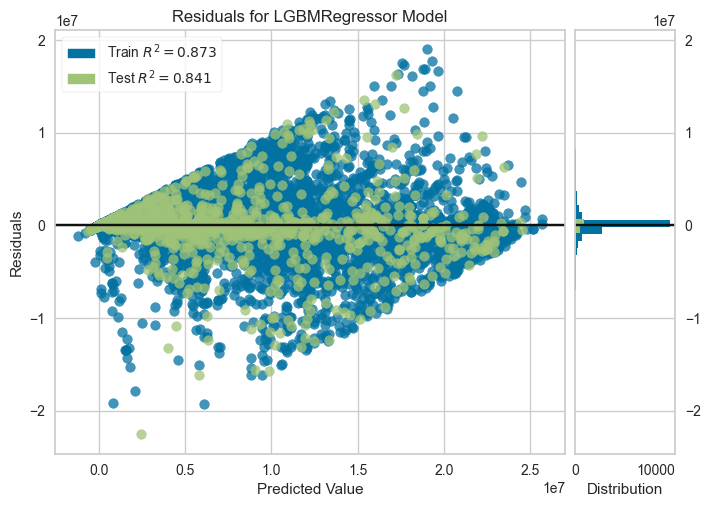

In [34]:
# plot residuals
plot_model(r2_tuned, plot='residuals')

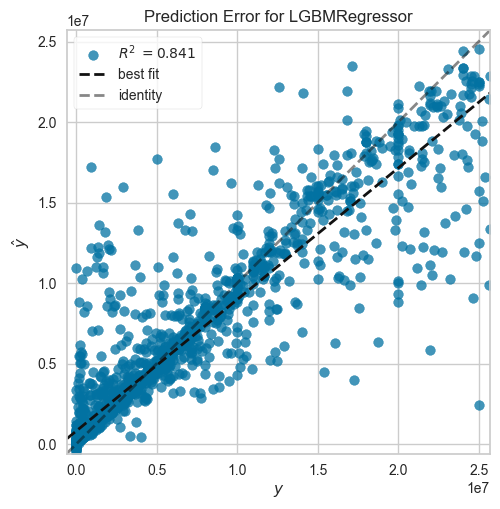

In [35]:
# plot error
plot_model(r2_tuned, plot='error')

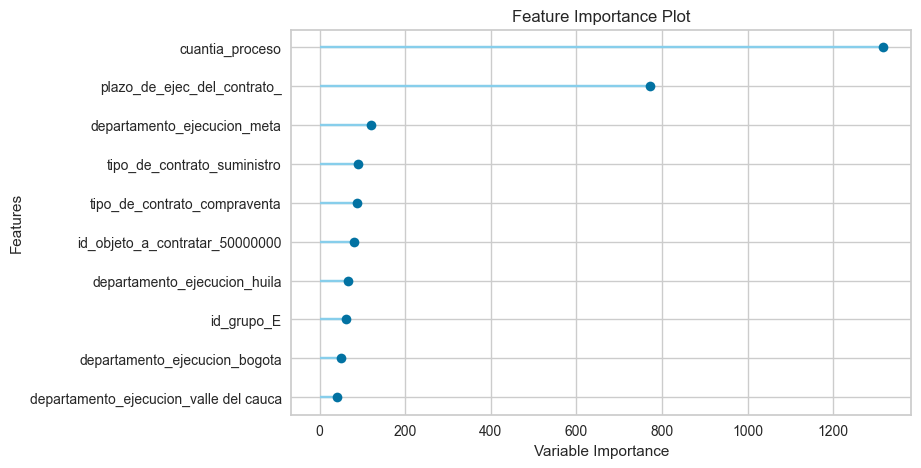

In [36]:
# plot feature
plot_model(r2_tuned, plot='feature')

In [ ]:
# plot parameter
plot_model(best, plot='parameter')

#### Optimización del modelo

In [ ]:
# tune model con choose_better
tuned_best_model = tune_model(best, choose_better=True)

In [ ]:
# tune model maximizando el R2
r2_tuned = tune_model(best, optimize='R2')

In [ ]:
# tune model con n_estimadores
ensemble_tuned = ensemble_model(best, n_estimators=100)

#### Análisis del mejor modelo despues del tuned

In [ ]:
# plot residuals
plot_model(ensemble_tuned, plot='residuals')

In [ ]:
# plot error
plot_model(ensemble_tuned, plot='error')

In [ ]:
# plot feature
#plot_model(ensemble_tuned, plot='feature')

In [ ]:
# interpretación del modelo
interpret_model(ensemble_tuned)